In [130]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils

import copy


In [131]:
# Gather information about the gabor feature channels

from feature_extraction import gabor_feature_extractor
n_ori=4; n_sf = 4;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
screen_eccen_deg=8.4
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)
n_sf = len(sf_unique)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)
n_ori = len(ori_unique)

In [180]:
# Load results of the fitting procedure
# subjects = np.arange(1,9)
subjects=[1]
n_subjects = len(subjects)

fitting_type = 'gabor_solo_OLS_4ori_4sf'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=1, \
                                  verbose=True) \
       for ss in subjects]
fig_save_folder=None

skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_OLS_4ori_4sf/Mar-06-2022_1201_54/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'n_ori_gabor', 'n_sf_gabor', 'gabor_nonlin_fn'])


In [181]:
out[0]['zscore_features']

True

In [182]:

feature_weights = np.concatenate([out[si]['best_params'][1][:,:,0] for si in range(n_subjects)], axis=0)
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)

n_voxels = feature_weights.shape[0]

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')
mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
print(np.shape(mean_orient_corr))
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)
print(np.shape(mean_sf_corr))

(19738, 4)
(19738, 4)
(19738, 4)
(19738, 4)


In [183]:
# about how well are the weights for different channels aligned with the correlation coefficient 
# measure of feature tuning?
# not bad for this smaller model, worse for the full one
correspondence = [np.corrcoef(feature_weights[ii,:], feature_corr[ii,:])[0,1] for ii in range(n_voxels)]
np.mean(correspondence) 

0.557911392953441

In [162]:
# find maxes. if they are constant across orient/SF, then set to nan.
preferred_ori_corr = np.argmax(mean_orient_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_corr[:,0:1], [1,n_ori])==mean_orient_corr, axis=1)
preferred_ori_corr[is_constant] = np.nan

preferred_sf_corr = np.argmax(mean_sf_corr, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_corr[:,0:1], [1,n_sf])==mean_sf_corr, axis=1)
preferred_sf_corr[is_constant] = np.nan

preferred_ori_weights = np.argmax(mean_orient_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_orient_weights[:,0:1], [1,n_ori])==mean_orient_weights, axis=1)
preferred_ori_weights[is_constant] = np.nan

preferred_sf_weights = np.argmax(mean_sf_weights, axis=1).astype(np.float32)
is_constant = np.all(np.tile(mean_sf_weights[:,0:1], [1,n_sf])==mean_sf_weights, axis=1)
preferred_sf_weights[is_constant] = np.nan

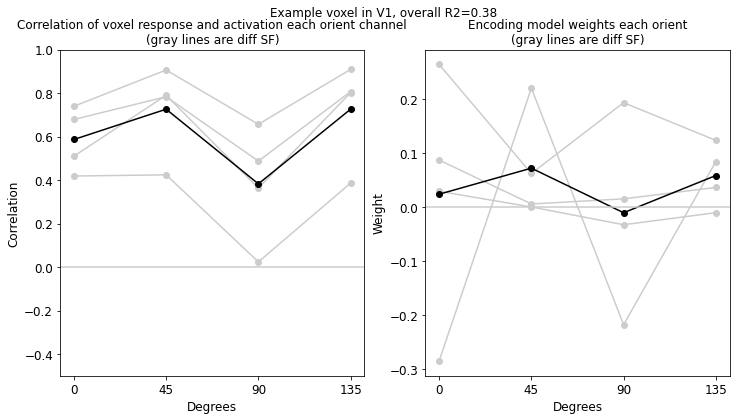

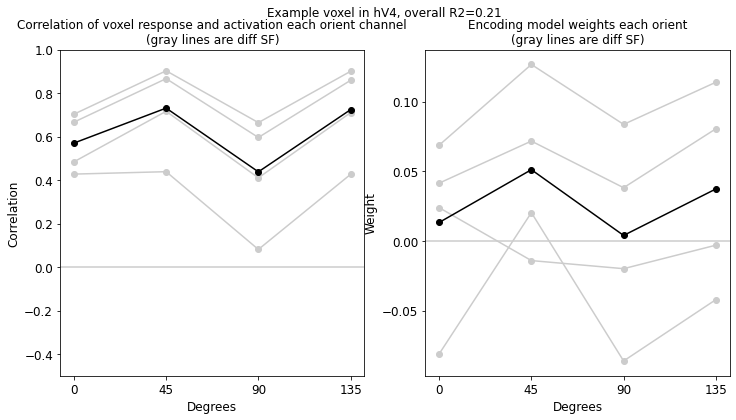

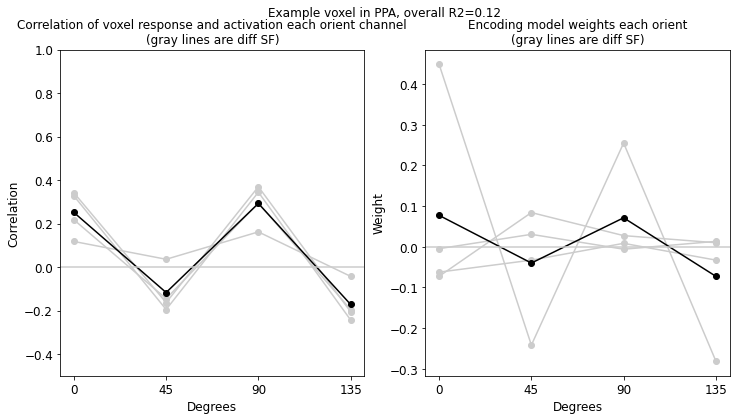

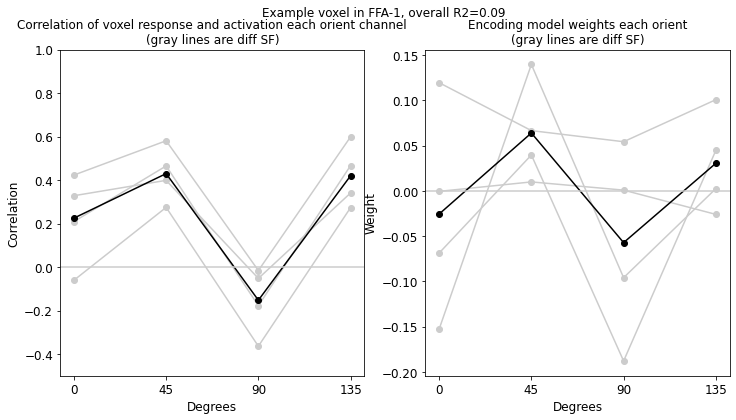

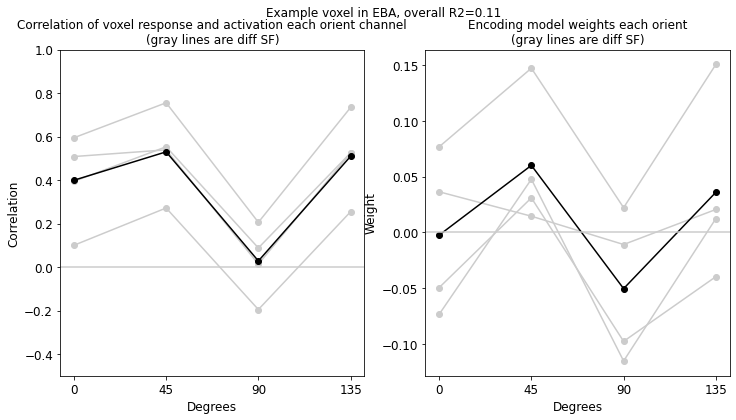

In [176]:
# Plotting orientation tuning for some example voxels

plot_utils.set_all_font_sizes(12)

si = 0;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

rnames = ['V1', 'hV4', 'PPA','FFA-1','EBA']

for rname in rnames:

    vinds = np.where(roi_def.get_indices_from_name(rname))[0]

    vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(ori_unique, allcorr_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(ori_unique,  mean_orient_corr[vidx,:],'-o',color='k')
    plt.xlabel('Degrees')
    plt.ylabel('Correlation')
    plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
    # plt.axhline(val_cc[vidx],color='k')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.xticks(np.arange(0,179,45))
    plt.ylim([-0.5,1])

    plt.subplot(1,2,2)
    plt.plot(ori_unique, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(ori_unique, mean_orient_weights[vidx,:],'-o',color='k')
    plt.xlabel('Degrees')
    plt.ylabel('Weight')
    plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    plt.xticks(np.arange(0,179,45))
    # plt.ylim([-1,1])

    plt.suptitle('Example voxel in %s, overall R2=%.2f'%(rname, val_r2[vidx]));



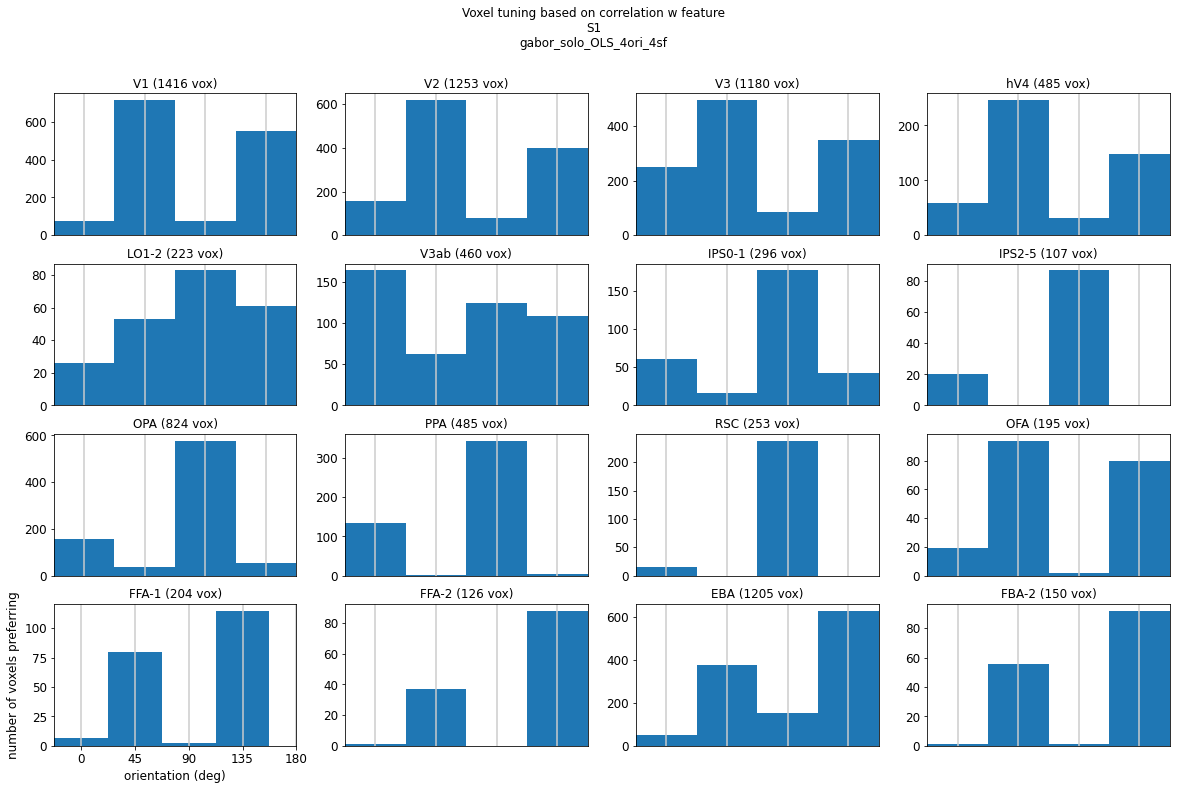

In [164]:
# Plot histograms of "preferred orientation"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = ori_unique[1] - ori_unique[0]
    neach = [np.sum(preferred_ori_corr[inds_this_roi]==oo) for oo in range(n_ori)]
    plt.bar(ori_unique, neach, width=spacing)

    plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'%(summary_plots.get_substr(out), fitting_type));


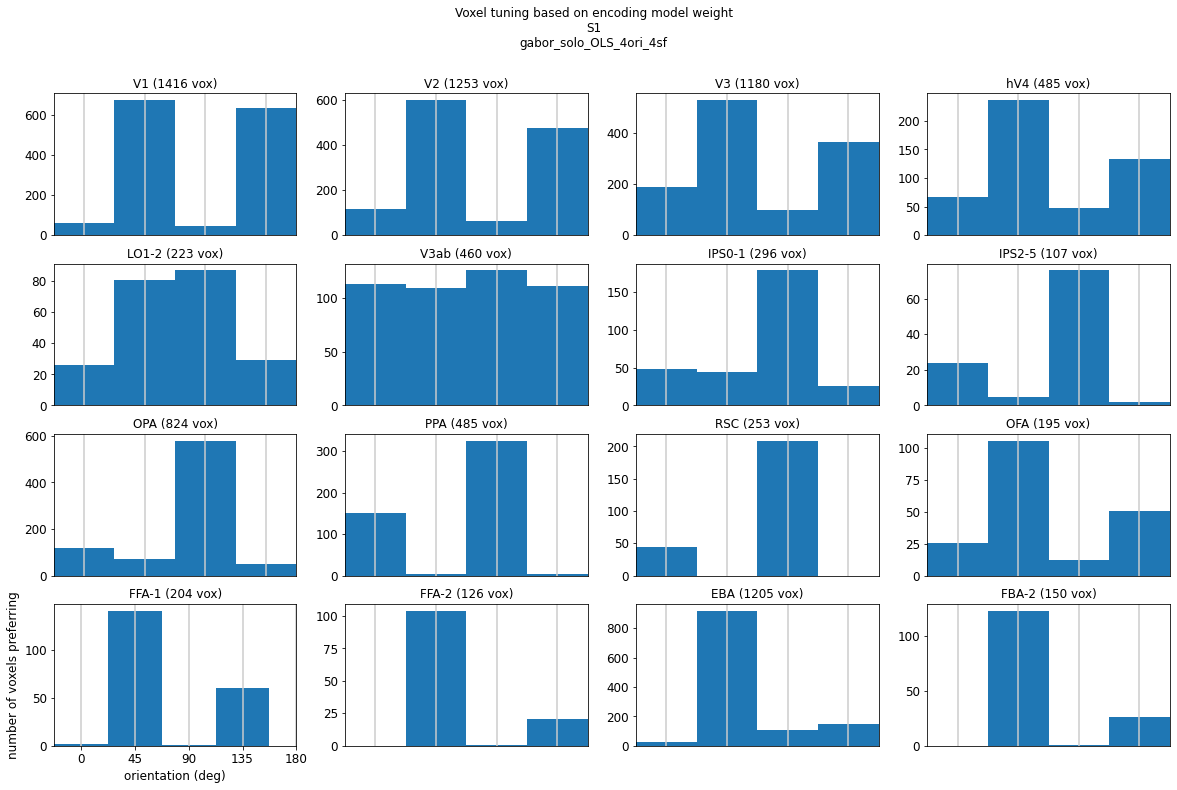

In [165]:
# Plot histograms of "preferred orientation"
# based on encoding model weights method (for comparison to corr coef)

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = ori_unique[1] - ori_unique[0]
    neach = [np.sum(preferred_ori_weights[inds_this_roi]==oo) for oo in range(n_ori)]
    plt.bar(ori_unique, neach, width=spacing)

    plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
        plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

    for ii in np.arange(0,181,45):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on encoding model weight\n%s\n%s'%(summary_plots.get_substr(out), fitting_type));


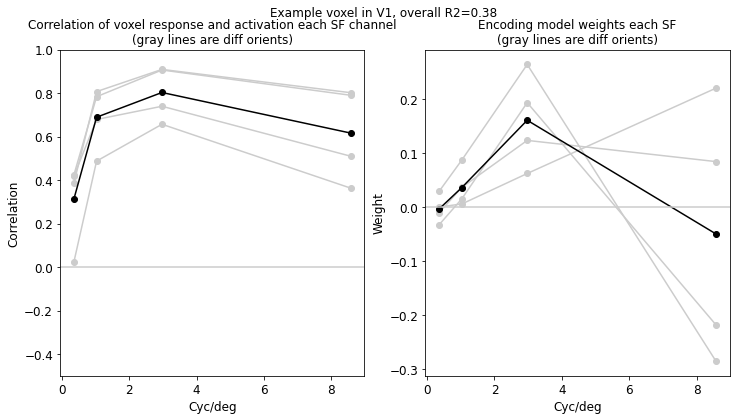

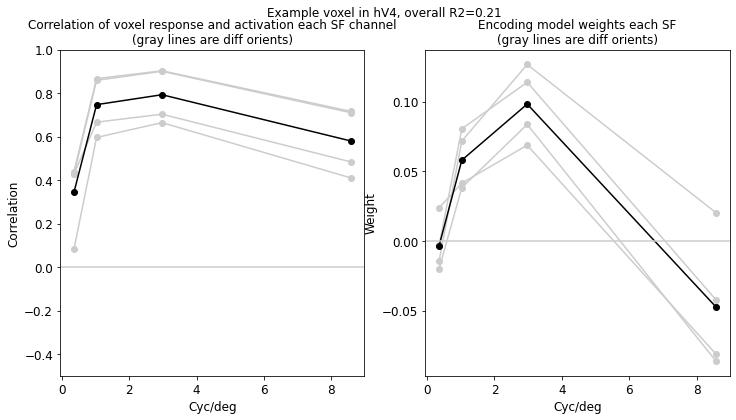

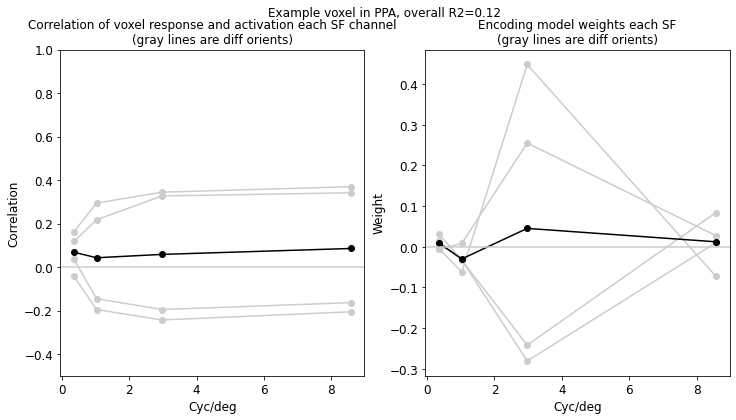

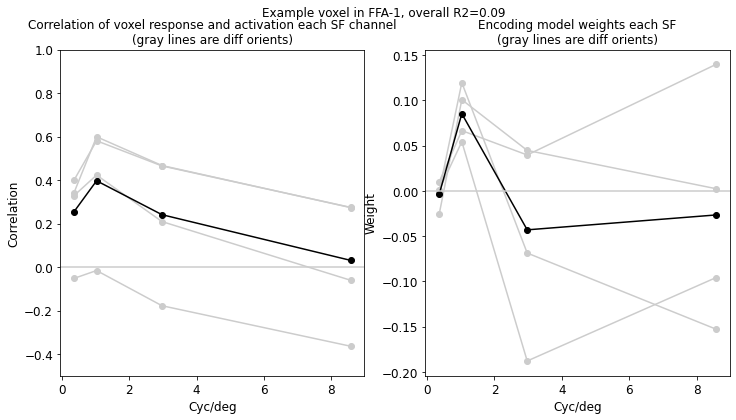

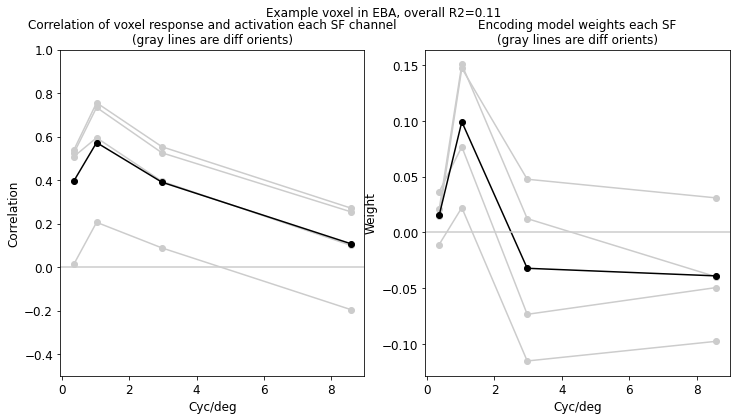

In [184]:
# Plotting spatial frequency tuning for some example voxels

plot_utils.set_all_font_sizes(12)

si = 0;

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

rnames = ['V1', 'hV4', 'PPA','FFA-1','EBA']

for rname in rnames:

    vinds = np.where(roi_def.get_indices_from_name(rname))[0]

    vidx = vinds[np.flip(np.argsort(val_r2[vinds]))[0]]

    plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(sf_unique, allcorr_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
    plt.plot(sf_unique,  mean_sf_corr[vidx,:],'-o',color='k')
    plt.xlabel('Cyc/deg')
    plt.ylabel('Correlation')
    plt.title('Correlation of voxel response and activation each SF channel\n(gray lines are diff orients)')
    # plt.axhline(val_cc[vidx],color='k')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
   
    plt.ylim([-0.5,1])

    plt.subplot(1,2,2)
    plt.plot(sf_unique, allw_reshaped[vidx,:,:].T,'-o',color=[0.8, 0.8, 0.8])
    plt.plot(sf_unique, mean_sf_weights[vidx,:],'-o',color='k')
    plt.xlabel('Cyc/deg')
    plt.ylabel('Weight')
    plt.title('Encoding model weights each SF\n(gray lines are diff orients)')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
   
    plt.suptitle('Example voxel in %s, overall R2=%.2f'%(rname, val_r2[vidx]));



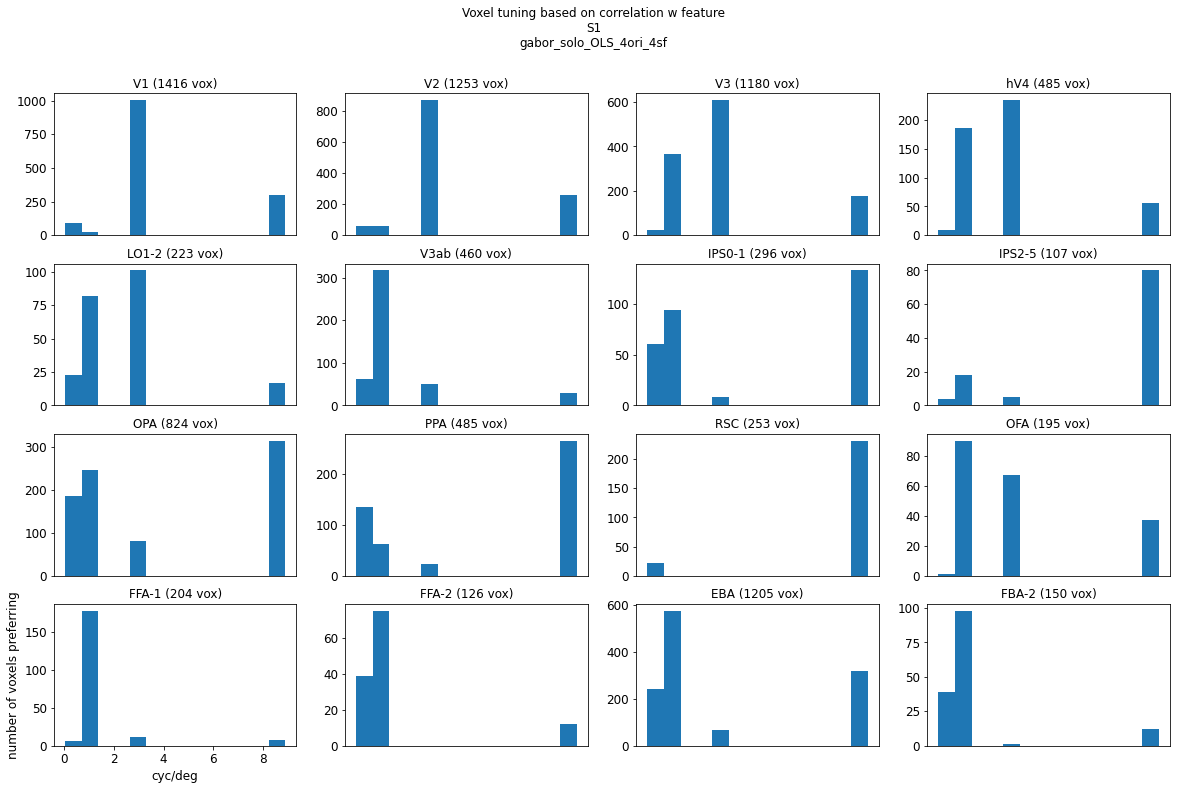

In [185]:
# Plot histograms of "preferred frequency"
# based on correlation coefficient method

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = sf_unique[1] - sf_unique[0]
    neach = [np.sum(preferred_sf_corr[inds_this_roi]==ff) for ff in range(n_sf)]
    plt.bar(sf_unique, neach, width=spacing)

#     plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('cyc/deg')
        plt.ylabel('number of voxels preferring')
#         plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

#     for ii in np.arange(0,181,45):
#         plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on correlation w feature\n%s\n%s'\
             %(summary_plots.get_substr(out), fitting_type));


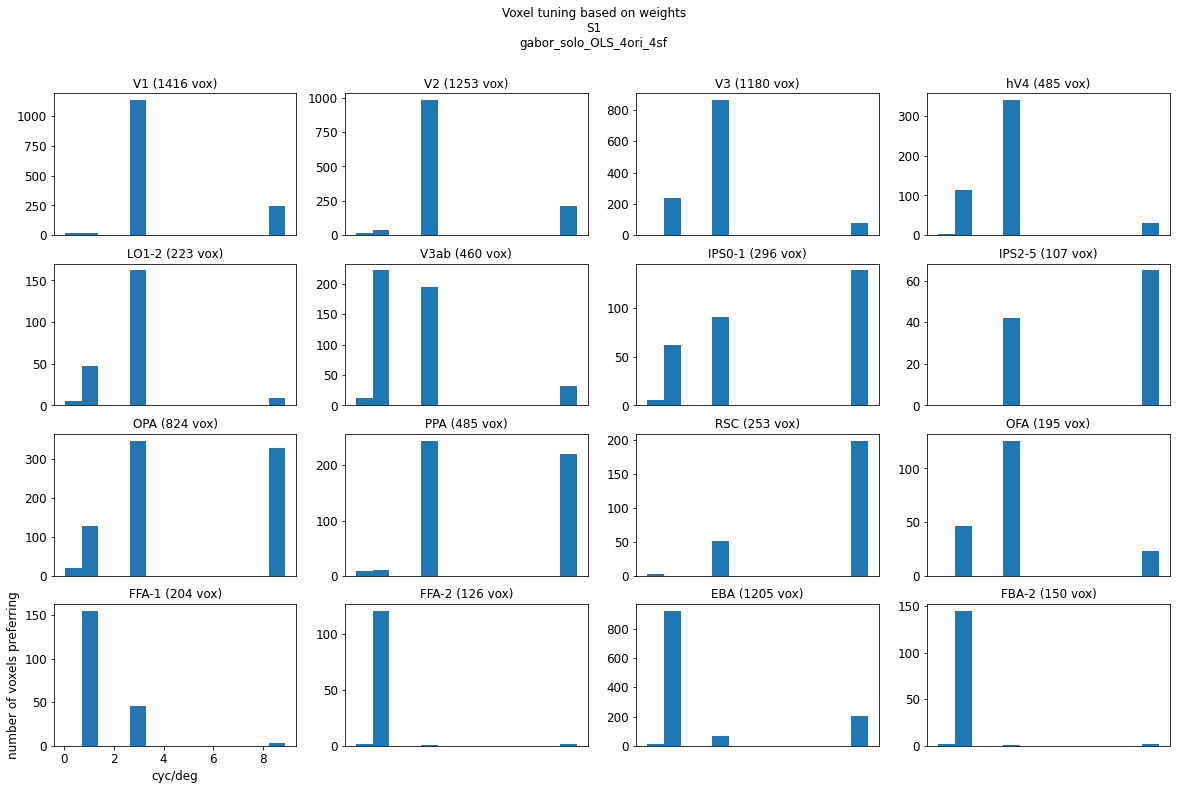

In [186]:
# Plot histograms of "preferred frequency
# based on weights

r2_cutoff = 0.01

val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)

abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,12))
npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil((n_rois)/npy))

pi=0
for ri in range(n_rois):

    inds_this_roi = roi_def.get_indices(ri) & abv_thresh
    
    pi+=1
    plt.subplot(npx,npy,pi)

    spacing = sf_unique[1] - sf_unique[0]
    neach = [np.sum(preferred_sf_weights[inds_this_roi]==ff) for ff in range(n_sf)]
    plt.bar(sf_unique, neach, width=spacing)

#     plt.xlim([-spacing/2,180-spacing/2])

    if pi==(npx-1)*npy+1:
        plt.xlabel('cyc/deg')
        plt.ylabel('number of voxels preferring')
#         plt.xticks(np.arange(0,181,45))
    else:
        plt.xticks([]);
#         plt.yticks([])

#     for ii in np.arange(0,181,45):
#         plt.axvline(ii,color=[0.8, 0.8, 0.8])

    plt.title('%s (%d vox)'%(roi_names[ri], np.sum(inds_this_roi)))

plt.suptitle('Voxel tuning based on weights\n%s\n%s'\
             %(summary_plots.get_substr(out), fitting_type));
